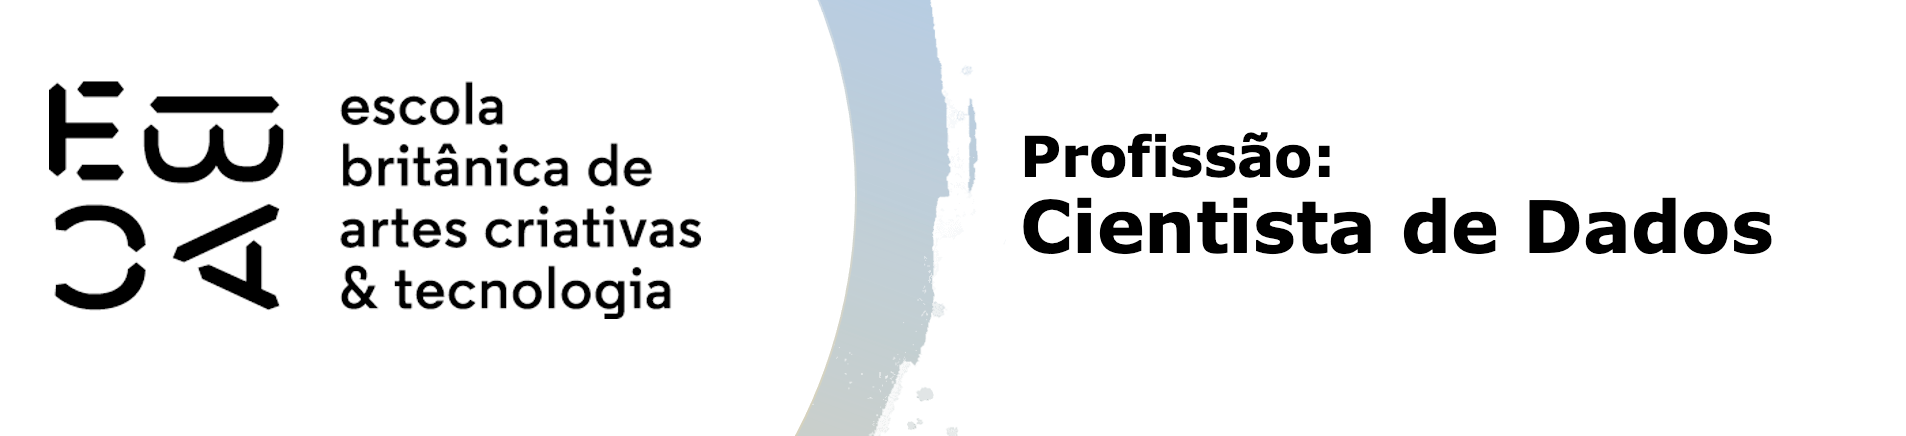

# Regressão IV - Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelo de previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

### 0. Importação de Pacotes e Dados

In [358]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import scipy.stats as ss 
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

%matplotlib inline

In [359]:
df = pd.read_csv('../Dados/previsao_de_renda_II.csv')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2,2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
3,2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
4,2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


In [360]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   data_ref               750000 non-null  object 
 1   index                  750000 non-null  int64  
 2   sexo                   750000 non-null  object 
 3   posse_de_veiculo       750000 non-null  object 
 4   posse_de_imovel        750000 non-null  object 
 5   qtd_filhos             750000 non-null  int64  
 6   tipo_renda             750000 non-null  object 
 7   educacao               750000 non-null  object 
 8   estado_civil           750000 non-null  object 
 9   tipo_residencia        750000 non-null  object 
 10  idade                  750000 non-null  int64  
 11  tempo_emprego          624240 non-null  float64
 12  qt_pessoas_residencia  750000 non-null  float64
 13  renda                  750000 non-null  float64
dtypes: float64(3), int64(3), object(8)
m

### 1. Limpeza e Preparação dos Dados

In [362]:
# Calcula a média do tempo_emprego
media = df.tempo_emprego.mean()

# Substitui os missings pela média
df["tempo_emprego"] = df["tempo_emprego"].fillna(value=df["tempo_emprego"].mean())

# Verifica se há dados missing
df.isna().sum()

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64

In [363]:
# Calcula o logaritmo da variável 'renda'
df['log_renda'] = np.log(df.renda)

In [364]:
# Transforma a data_ref em coluna ao invés de index
df.reset_index(inplace=True)

# Mostra o df sem o índice 
df.head()

,level_0,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,log_renda
0,0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,9.318131
1,1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81,7.793508
2,2,2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66,9.528769
3,3,2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84,7.767196
4,4,2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78,6.673020


In [365]:
# Remove os dias das datas
df['data_ref'] = [x[:-3] for x in df['data_ref']]

# Mostra os meses e anos analisados
df.data_ref.unique()

array(['2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06',
       '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
       '2016-01', '2016-02', '2016-03'], dtype=object)

In [366]:
# Seleciona as linhas com os 3 últimos meses
meses = ['2016-01', '2016-02', '2016-03']

# Monta a base de teste com os meses selecionados
teste = df.loc[df['data_ref'].isin(meses)].copy()

# Cria a base de treino
treino = df.loc[~df['data_ref'].isin(meses)].copy()

In [367]:
# Remove as colunas 'level_0' e 'index' de cada base
treino.drop(columns=['level_0', 'index'], inplace=True)
teste.drop(columns=['level_0', 'index'], inplace=True)

In [368]:
# Mostra a base de treino
treino.head()

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,log_renda
0,2015-01,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,9.318131
1,2015-01,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81,7.793508
2,2015-01,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66,9.528769
3,2015-01,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84,7.767196
4,2015-01,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78,6.673020


In [369]:
# Mostra a base de teste
teste.head()

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,log_renda
600000,2016-01,F,N,S,0,Pensionista,Médio,Casado,Casa,61,7.746165,2.0,2137.61,7.667444
600001,2016-01,F,N,S,2,Servidor público,Superior completo,Casado,Casa,27,9.301370,4.0,13884.35,9.538518
600002,2016-01,F,S,S,3,Assalariado,Médio,Casado,Casa,38,10.967123,5.0,11042.47,9.309504
600003,2016-01,M,S,S,3,Servidor público,Médio,Casado,Casa,35,5.553425,5.0,1333.82,7.195802
600004,2016-01,F,S,N,0,Assalariado,Médio,Viúvo,Casa,63,9.265753,1.0,17633.03,9.777529


### 2. Modelo Inicial

In [371]:
r1 = smf.ols('''
    log_renda ~
    sexo + posse_de_veiculo + posse_de_imovel +
    qtd_filhos + tipo_renda + educacao + estado_civil +
    tipo_residencia + idade + tempo_emprego + 
    qt_pessoas_residencia
    ''', data=treino).fit()
r1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                 1.947e+04
Date:                Mon, 16 Dec 2024   Prob (F-statistic):               0.00
Time:                        20:21:56   Log-Likelihood:            -7.9748e+05
No. Observations:              600000   AIC:                         1.595e+06
Df Residuals:                  599975   BIC:                         1.595e+06
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            7.6405      0.048    160.310      0.000       7.547       7.734
sexo[T.M]                            0.1354      0.003     48.568      0.000       0.130       0.141
posse_de_veiculo[T.S]                0.0055      0.003      2.087      0.037       0.000       0.011
posse_de_imovel[T.S]                 0.1852      0.003     71.417      0.000       0.180       0.190
tipo_renda[T.Bolsista]              -0.2166      0.052     -4.129      0.000      -0.319      -0.114
tipo_renda[T.Empresário]             0.1452      0.003     48.527      0.000       0.139       0.151
tipo_renda[T.Pensionista]           -0.2974      0.004    -69.709      0.000      -0.306      -0.289
tipo_renda[T.Servidor público]       0.1333      0.004     30.253      0.000       0.125       0.142
educacao[T.Médio]                    0.0301      0.011      2.689      0.007       0.008       0.052
educacao[T.Pós graduação]            0.1542      0.038      4.043      0.000       0.079       0.229
educacao[T.Superior completo]        0.1233      0.011     10.896      0.000       0.101       0.146
educacao[T.Superior incompleto]      0.0434      0.013      3.424      0.001       0.019       0.068
estado_civil[T.Separado]             0.1793      0.023      7.792      0.000       0.134       0.224
estado_civil[T.Solteiro]             0.1614      0.023      7.151      0.000       0.117       0.206
estado_civil[T.União]                0.0097      0.005      2.161      0.031       0.001       0.019
estado_civil[T.Viúvo]                0.1634      0.023      7.027      0.000       0.118       0.209
tipo_residencia[T.Casa]             -0.0881      0.010     -8.651      0.000      -0.108      -0.068
tipo_residencia[T.Com os pais]      -0.0557      0.012     -4.823      0.000      -0.078      -0.033
tipo_residencia[T.Comunitário]      -0.1404      0.021     -6.835      0.000      -0.181      -0.100
tipo_residencia[T.Estúdio]          -0.1408      0.017     -8.203      0.000      -0.174      -0.107
tipo_residencia[T.Governamental]    -0.0942      0.012     -7.773      0.000      -0.118      -0.070
qtd_filhos                          -0.1498      0.022     -6.668      0.000      -0.194      -0.106
idade                                0.0042      0.000     26.893      0.000       0.004       0.004
tempo_emprego                        0.1290      0.000    619.711      0.000       0.129       0.129
qt_pessoas_residencia                0.1554      0.022      6.929      0.000       0.111       0.199
==============================================================================
Omnibus:                     1088.041   Durbin-Watson:                   1.234
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              957.929
Skew:             

## 3. Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

> Verificando se os resíduos têm distribuição Normal

Text(0.5, 9.444444444444459, 'Resíduos')

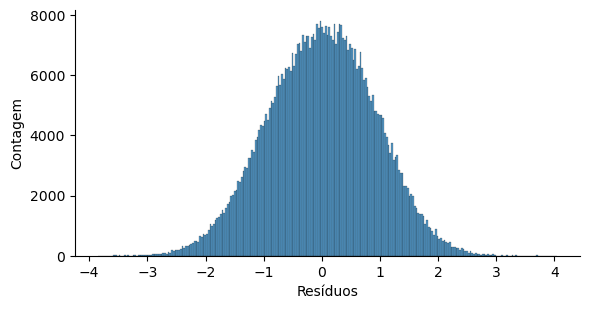

In [374]:
sns.displot(r1.resid, height=3, aspect=2)
plt.ylabel('Contagem')
plt.xlabel('Resíduos')

> Os resíduos apresentam distribuição normal, uma vez que seu histograma apresenta o formato de uma gaussiana centrada em zero.

Text(0.5, 0, 'Valores Preditos')

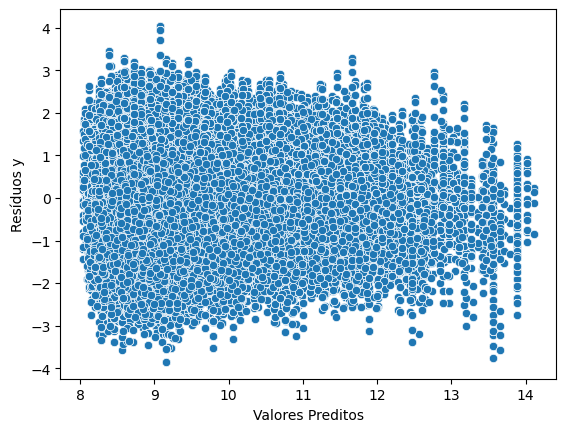

In [376]:
sns.scatterplot(x = r1.predict(), y = r1.resid)
plt.ylabel('Resíduos y')
plt.xlabel('Valores Preditos')

Text(0, 0.5, 'Resíduos y')

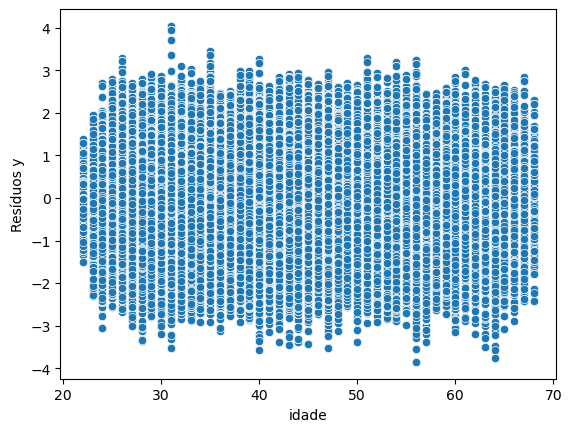

In [377]:
sns.scatterplot(x='idade', y=r1.resid, data=treino)
plt.ylabel('Resíduos y')

Text(0, 0.5, 'Resíduos y')

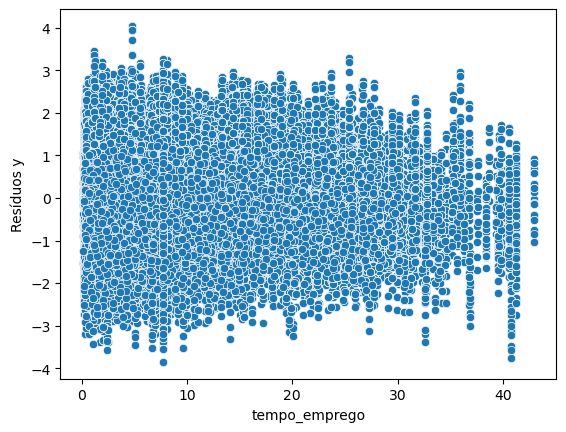

In [378]:
sns.scatterplot(x='tempo_emprego', y=r1.resid, data=treino)
plt.ylabel('Resíduos y')

Text(0, 0.5, 'Resíduos y')

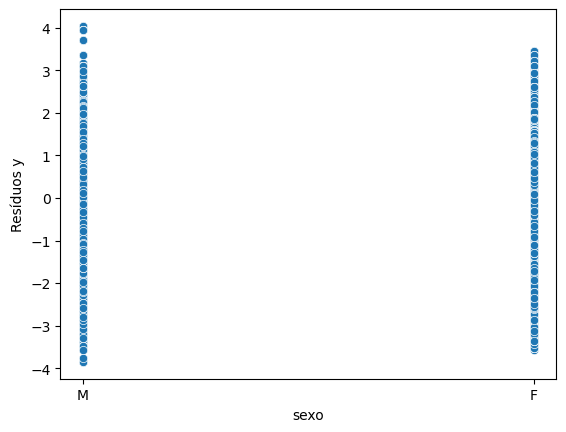

In [379]:
sns.scatterplot(x='sexo', y=r1.resid, data=treino)
plt.ylabel('Resíduos y')

Text(0, 0.5, 'Resíduos y')

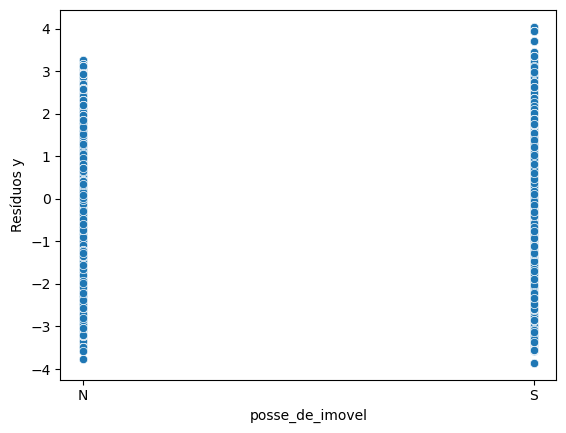

In [380]:
sns.scatterplot(x='posse_de_imovel', y=r1.resid, data=treino)
plt.ylabel('Resíduos y')

Text(0, 0.5, 'Resíduos y')

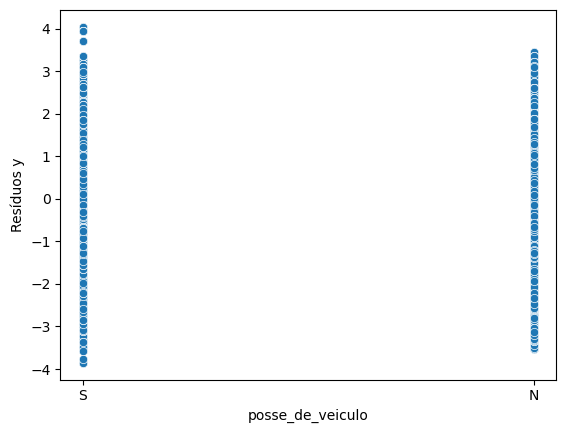

In [381]:
sns.scatterplot(x='posse_de_veiculo', y=r1.resid, data=treino)
plt.ylabel('Resíduos y')

Text(0, 0.5, 'Resíduos y')

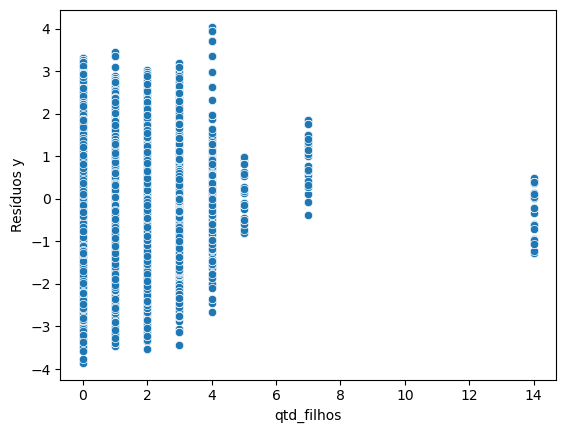

In [382]:
sns.scatterplot(x='qtd_filhos', y=r1.resid, data=treino)
plt.ylabel('Resíduos y')

Text(0, 0.5, 'Resíduos y')

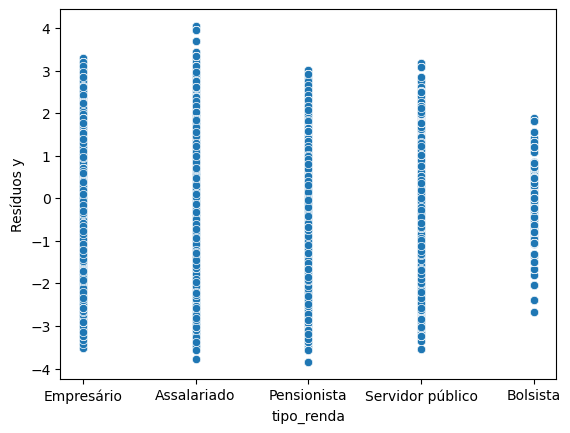

In [383]:
sns.scatterplot(x='tipo_renda', y=r1.resid, data=treino)
plt.ylabel('Resíduos y')

Text(0, 0.5, 'Resíduos y')

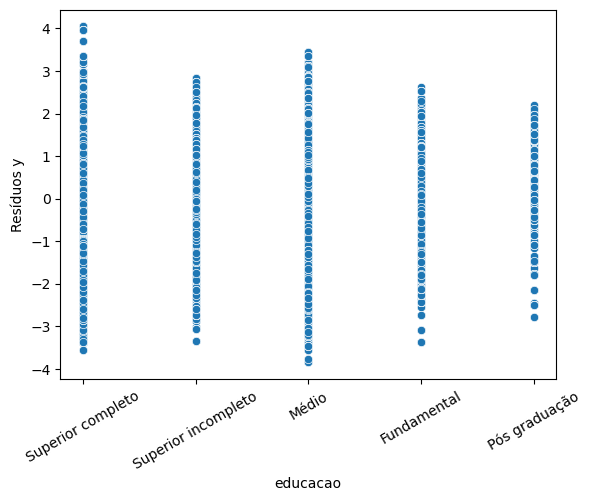

In [384]:
sns.scatterplot(x='educacao', y=r1.resid, data=treino)
plt.tick_params(axis='x', rotation=30)
plt.ylabel('Resíduos y')

Text(0, 0.5, 'Resíduos y')

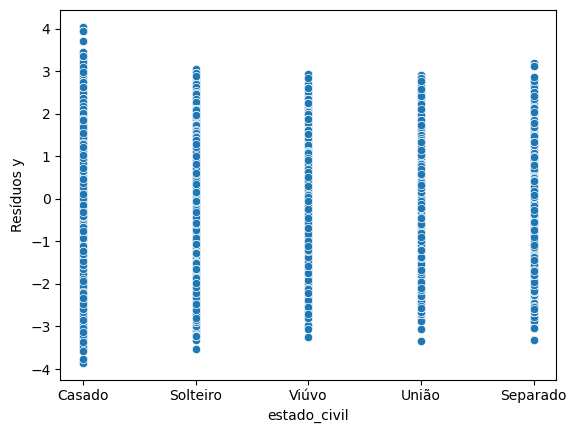

In [385]:
sns.scatterplot(x='estado_civil', y=r1.resid, data=treino) 
plt.ylabel('Resíduos y')

Text(0, 0.5, 'Resíduos y')

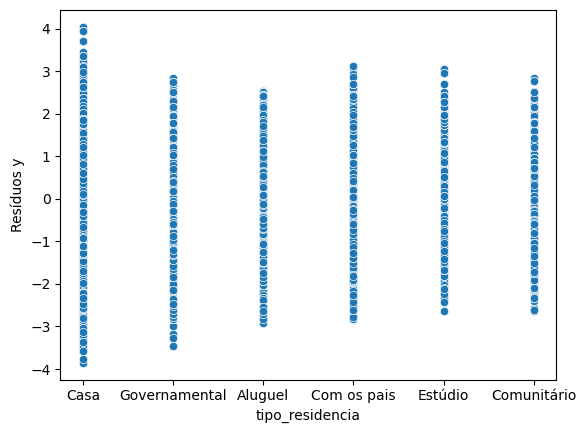

In [386]:
sns.scatterplot(x='tipo_residencia', y=r1.resid, data=treino)
plt.ylabel('Resíduos y')

Text(0, 0.5, 'Resíduos y')

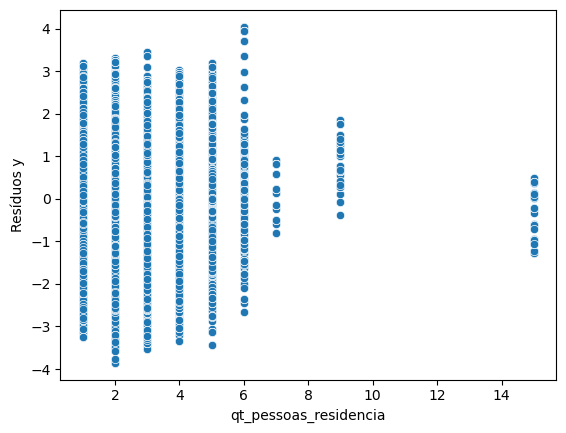

In [387]:
sns.scatterplot(x='qt_pessoas_residencia', y=r1.resid, data=treino)
plt.ylabel('Resíduos y')

> Avaliando os gráficos dos resíduos em função de cada variável, não são notados padrões, tal como esperado. 

> Para avaliar se há depedência entre valores médios dos resíduos e meses de refêrencia, será criado um dataframe com estas variáveis.

In [390]:
avaliacao = pd.DataFrame()
avaliacao['meses'] = treino['data_ref'].copy()
avaliacao['residuos'] = r1.resid

In [391]:
media_res = avaliacao.groupby('meses')[['residuos']].mean()
avaliacao = avaliacao.merge(media_res, on='meses', how='left')
avaliacao

,meses,residuos_x,residuos_y
0,2015-01,-1.306317,-0.966454
1,2015-01,-1.616948,-0.966454
2,2015-01,0.226172,-0.966454
3,2015-01,-0.808652,-0.966454
4,2015-01,-1.808845,-0.966454
...,...,...,...
599995,2015-12,-1.283902,-0.681977
599996,2015-12,-0.764651,-0.681977
599997,2015-12,0.112130,-0.681977
599998,2015-12,0.603366,-0.681977


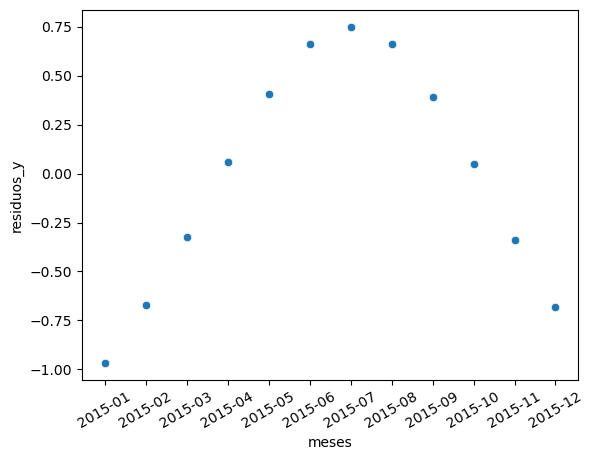

In [392]:
sns.scatterplot(x='meses', y='residuos_y', data=avaliacao)
plt.tick_params(axis='x', rotation=30)

> O gráfico mostra que há influência do mês de referência sobre o valor médio do resíduo do ajuste, uma vez que a distribuição destes resíduos tem a forma de uma parábola.

> Verificando se a variância da variável resposta é conforme os valores preditos:
> 
> O gráfico resultante tem formato análogo ao obtido com a variável _tempo_emprego_, implicando que a variância da variável resposta é conforme os valores preditos, que por sua vez, variam de acordo com a variável mencionada.

## 4. Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

> Verificando se há pontos discrepantes pelo _studentized residuals_:

In [397]:
# Calcula os pontos influentes do ajuste
influence = r1.get_influence()

# Determina o studentized residuals a partir dos pontos de influencia
stud_resid = influence.resid_studentized_internal

# Cria um dataframe com os números das linhas e valores do studentized residuals
studentized_residuals = pd.DataFrame({'Point': [i for i in range(len(stud_resid))],
                                     'Student Residual': stud_resid})

Text(0, 0.5, 'Studentized Residuals')

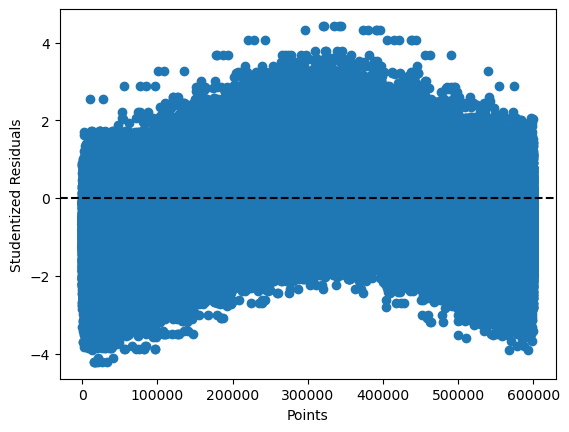

In [398]:
# Cria um gráfico com as colunas do dataframe criado
plt.scatter(x = studentized_residuals['Point'], y = studentized_residuals['Student Residual'])
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Points')
plt.ylabel('Studentized Residuals')

> De acordo com o gráfico do Studentized Residuals, há poucos pontos discrepantes, sendo apenas aqueles maiores do que 2, distante aos outros.

> Verificando os pontos influentes pelo _Cook's Distance_:

In [401]:
# Calcula a distancia de cooks para cada ponto
cooks_d = influence.cooks_distance[0]

# Cria um dataframe com os pontos e respectivas distancias
cooks = pd.DataFrame({'Point': [i for i in range(len(stud_resid))],
                      "Cook's Distance": cooks_d})

Pontos influentes (Cook's distance > 0.0002): 172


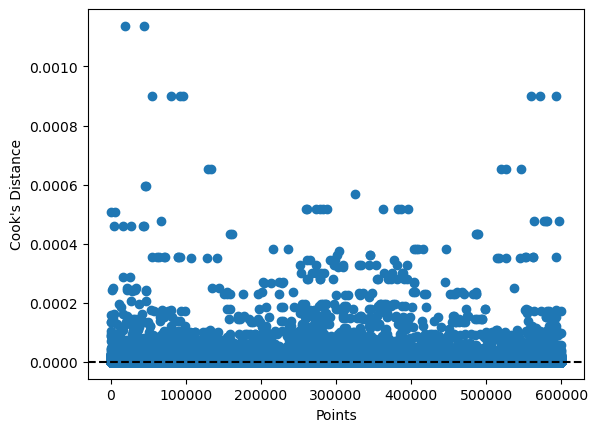

In [402]:
# Cria um gráfico com as colunas do dataframe criado
plt.scatter(x = cooks['Point'], y = cooks["Cook's Distance"])
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Points')
plt.ylabel("Cook's Distance")

# Calcula o numero de pontos influentes pela cook's distance
pontos_influencia = np.where(cooks_d > 0.0002)[0]
print(f'Pontos influentes (Cook\'s distance > 0.0002): {len(pontos_influencia)}')

> Avaliando a Cook's Distance do ajuste, há 172 pontos influentes, nas quais a distância é maior do que 0.0002.

## 5. Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

> Selecionando apenas as variáveis numéricas da base de treino para a obtenção da Matriz de correlação de Spearman:

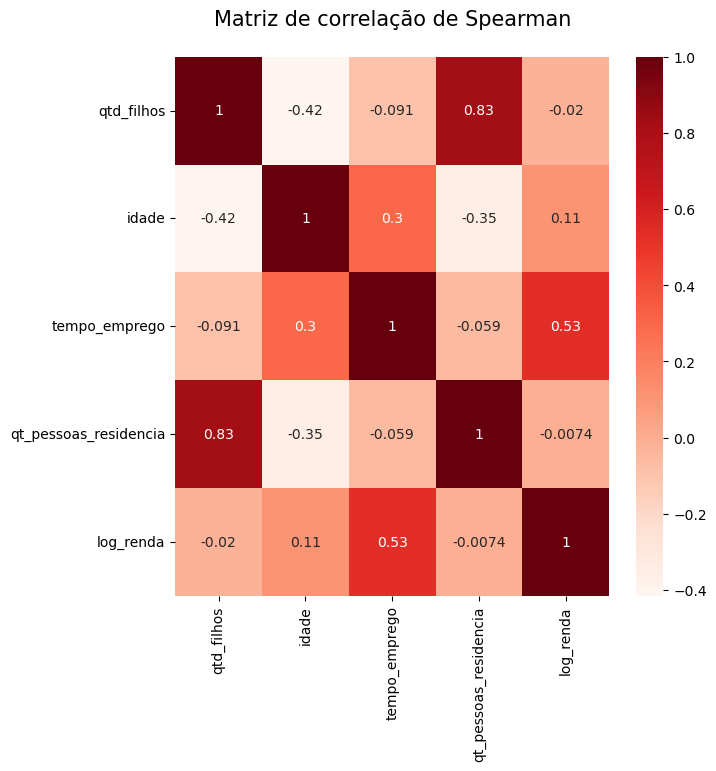

In [406]:
# Monta a matriz de correlacao de spearman com os valores da base de treino
treino_corr = (treino.select_dtypes(include=['float', 'int'])
               .drop(columns='renda').corr("spearman"))

# Faz o mapa da matriz de correlação:
plt.figure(figsize = (7,7))
sns.heatmap(treino_corr, annot = True, cmap="Reds")
plt.title("Matriz de correlação de Spearman\n", fontsize=15)
plt.show()

> Cálculo do VIF para todas as variáveis da base de treino.

In [408]:
# Converte as variáveis não-numéricas em dummies
treino_dumm = pd.get_dummies(treino.drop(columns=['data_ref', 'renda']), drop_first=True, dtype=float)

# Monta um dataframe com todas as variáveis (numéricas e dummies)
vars_vif = pd.DataFrame()
vars_vif["VIF Factor"] = [vif(treino_dumm, i) for i in range(treino_dumm.shape[1])]
vars_vif["Feature"] = treino_dumm.columns

# Calcula o VIF de toda a base de treino
vars_vif.round(2)

,VIF Factor,Feature
0,44.93,qtd_filhos
1,34.79,idade
2,4.87,tempo_emprego
3,323.62,qt_pessoas_residencia
4,100.50,log_renda
5,1.83,sexo_M
6,1.97,posse_de_veiculo_S
7,3.27,posse_de_imovel_S
8,1.00,tipo_renda_Bolsista
9,1.48,tipo_renda_Empresário


> De acordo com os valores da matriz de correlação de Spearman, a variável numérica que apresenta correlação significativa com a _log(renda)_ é o _tempo_emprego_, cuja correlação foi próxima a 0.5. Por outro lado, os resultados do VIF mostram que, com excessão da _tempo_emprego_, todas as variáveis numéricas são multicolineares.

## 6. Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

> Como foi visto com a matriz de correlação de Spears, a única variável numérica que realmente influencia a variável resposta é a _tempo_emprego_, além disso, todas as outras numéricas apresentam alto VIF. Tais informações mostram que elas podem ser desconsideradas no ajuste.

In [412]:
# Ajuste sem as variaveis 'qtd_filhos', 'qt_pessoas_residencia' e 'idade'
r2 = smf.ols('''
    log_renda ~
    sexo + posse_de_veiculo + posse_de_imovel + 
    tipo_renda + educacao + estado_civil +
    tipo_residencia + tempo_emprego
    ''', data=treino).fit()
r2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                 2.218e+04
Date:                Mon, 16 Dec 2024   Prob (F-statistic):               0.00
Time:                        20:25:07   Log-Likelihood:            -7.9788e+05
No. Observations:              600000   AIC:                         1.596e+06
Df Residuals:                  599978   BIC:                         1.596e+06
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            8.1002      0.015    529.695      0.000       8.070       8.130
sexo[T.M]                            0.1300      0.003     46.726      0.000       0.125       0.135
posse_de_veiculo[T.S]                0.0030      0.003      1.115      0.265      -0.002       0.008
posse_de_imovel[T.S]                 0.1903      0.003     73.559      0.000       0.185       0.195
tipo_renda[T.Bolsista]              -0.1850      0.052     -3.527      0.000      -0.288      -0.082
tipo_renda[T.Empresário]             0.1441      0.003     48.159      0.000       0.138       0.150
tipo_renda[T.Pensionista]           -0.2301      0.003    -66.179      0.000      -0.237      -0.223
tipo_renda[T.Servidor público]       0.1313      0.004     29.801      0.000       0.123       0.140
educacao[T.Médio]                    0.0312      0.011      2.785      0.005       0.009       0.053
educacao[T.Pós graduação]            0.1600      0.038      4.194      0.000       0.085       0.235
educacao[T.Superior completo]        0.1178      0.011     10.401      0.000       0.096       0.140
educacao[T.Superior incompleto]      0.0207      0.013      1.638      0.101      -0.004       0.045
estado_civil[T.Separado]             0.0331      0.005      6.379      0.000       0.023       0.043
estado_civil[T.Solteiro]            -0.0002      0.004     -0.060      0.952      -0.007       0.007
estado_civil[T.União]                0.0035      0.005      0.780      0.436      -0.005       0.012
estado_civil[T.Viúvo]                0.0250      0.006      4.092      0.000       0.013       0.037
tipo_residencia[T.Casa]             -0.0740      0.010     -7.271      0.000      -0.094      -0.054
tipo_residencia[T.Com os pais]      -0.0628      0.012     -5.438      0.000      -0.085      -0.040
tipo_residencia[T.Comunitário]      -0.1209      0.021     -5.884      0.000      -0.161      -0.081
tipo_residencia[T.Estúdio]          -0.1247      0.017     -7.269      0.000      -0.158      -0.091
tipo_residencia[T.Governamental]    -0.0788      0.012     -6.501      0.000      -0.103      -0.055
tempo_emprego                        0.1307      0.000    656.957      0.000       0.130       0.131
==============================================================================
Omnibus:                     1078.915   Durbin-Watson:                   1.235
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              951.734
Skew:                          -0.053   Prob(JB):                    2.16e-207
Kurtosis:                       2.836   Cond. No.                         442.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is corre

> O novo ajuste apresentou alto p-value para a variável _posse_de_veiculo_, levando-a a ser removida.

In [414]:
# Ajuste sem a variavel 'posse_de_veiculo'
r3 = smf.ols('''
    log_renda ~
    sexo + posse_de_imovel + 
    tipo_renda + educacao + estado_civil +
    tipo_residencia + tempo_emprego
    ''', data=treino).fit()
r3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                 2.329e+04
Date:                Mon, 16 Dec 2024   Prob (F-statistic):               0.00
Time:                        20:25:33   Log-Likelihood:            -7.9788e+05
No. Observations:              600000   AIC:                         1.596e+06
Df Residuals:                  599979   BIC:                         1.596e+06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            8.1008      0.015    530.114      0.000       8.071       8.131
sexo[T.M]                            0.1311      0.003     49.952      0.000       0.126       0.136
posse_de_imovel[T.S]                 0.1903      0.003     73.559      0.000       0.185       0.195
tipo_renda[T.Bolsista]              -0.1862      0.052     -3.549      0.000      -0.289      -0.083
tipo_renda[T.Empresário]             0.1441      0.003     48.187      0.000       0.138       0.150
tipo_renda[T.Pensionista]           -0.2304      0.003    -66.435      0.000      -0.237      -0.224
tipo_renda[T.Servidor público]       0.1313      0.004     29.796      0.000       0.123       0.140
educacao[T.Médio]                    0.0314      0.011      2.798      0.005       0.009       0.053
educacao[T.Pós graduação]            0.1610      0.038      4.221      0.000       0.086       0.236
educacao[T.Superior completo]        0.1182      0.011     10.444      0.000       0.096       0.140
educacao[T.Superior incompleto]      0.0210      0.013      1.662      0.097      -0.004       0.046
estado_civil[T.Separado]             0.0327      0.005      6.312      0.000       0.023       0.043
estado_civil[T.Solteiro]            -0.0006      0.004     -0.168      0.867      -0.008       0.007
estado_civil[T.União]                0.0033      0.004      0.727      0.467      -0.006       0.012
estado_civil[T.Viúvo]                0.0247      0.006      4.049      0.000       0.013       0.037
tipo_residencia[T.Casa]             -0.0739      0.010     -7.260      0.000      -0.094      -0.054
tipo_residencia[T.Com os pais]      -0.0627      0.012     -5.432      0.000      -0.085      -0.040
tipo_residencia[T.Comunitário]      -0.1205      0.021     -5.864      0.000      -0.161      -0.080
tipo_residencia[T.Estúdio]          -0.1244      0.017     -7.252      0.000      -0.158      -0.091
tipo_residencia[T.Governamental]    -0.0787      0.012     -6.497      0.000      -0.102      -0.055
tempo_emprego                        0.1307      0.000    657.132      0.000       0.130       0.131
==============================================================================
Omnibus:                     1079.137   Durbin-Watson:                   1.235
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              951.910
Skew:                          -0.053   Prob(JB):                    1.97e-207
Kurtosis:                       2.836   Cond. No.                         442.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> De acordo com a distância de cooks, foram vistos 172 pontos influentes. Vamos removê-los do ajuste.

In [416]:
# Insere os valores da Distância de Cooks na base de treino
treino["Cook's D"] = cooks["Cook's Distance"].copy()

# Remove as linhas onde Cook's Distance > 0.0002
treino = treino[treino["Cook's D"] < 0.0002]

> Fazendo o modelo final na base de treino com as condições acima:

In [418]:
# Ajuste sem as variaveis mencionadas e Cook's D < 0.0002
r4 = smf.ols('''
    log_renda ~
    sexo + posse_de_imovel + 
    tipo_renda + educacao + estado_civil +
    tipo_residencia + tempo_emprego
    ''', data=treino).fit()
r4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                 2.330e+04
Date:                Mon, 16 Dec 2024   Prob (F-statistic):               0.00
Time:                        20:26:02   Log-Likelihood:            -7.9740e+05
No. Observations:              599828   AIC:                         1.595e+06
Df Residuals:                  599807   BIC:                         1.595e+06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            8.1009      0.015    530.340      0.000       8.071       8.131
sexo[T.M]                            0.1310      0.003     49.942      0.000       0.126       0.136
posse_de_imovel[T.S]                 0.1905      0.003     73.637      0.000       0.185       0.196
tipo_renda[T.Bolsista]              -0.2031      0.062     -3.298      0.001      -0.324      -0.082
tipo_renda[T.Empresário]             0.1449      0.003     48.442      0.000       0.139       0.151
tipo_renda[T.Pensionista]           -0.2302      0.003    -66.400      0.000      -0.237      -0.223
tipo_renda[T.Servidor público]       0.1315      0.004     29.868      0.000       0.123       0.140
educacao[T.Médio]                    0.0313      0.011      2.797      0.005       0.009       0.053
educacao[T.Pós graduação]            0.2134      0.040      5.316      0.000       0.135       0.292
educacao[T.Superior completo]        0.1182      0.011     10.445      0.000       0.096       0.140
educacao[T.Superior incompleto]      0.0210      0.013      1.661      0.097      -0.004       0.046
estado_civil[T.Separado]             0.0326      0.005      6.294      0.000       0.022       0.043
estado_civil[T.Solteiro]            -0.0015      0.004     -0.416      0.677      -0.009       0.006
estado_civil[T.União]                0.0033      0.004      0.730      0.465      -0.006       0.012
estado_civil[T.Viúvo]                0.0246      0.006      4.036      0.000       0.013       0.037
tipo_residencia[T.Casa]             -0.0741      0.010     -7.282      0.000      -0.094      -0.054
tipo_residencia[T.Com os pais]      -0.0628      0.012     -5.440      0.000      -0.085      -0.040
tipo_residencia[T.Comunitário]      -0.1205      0.021     -5.868      0.000      -0.161      -0.080
tipo_residencia[T.Estúdio]          -0.1246      0.017     -7.264      0.000      -0.158      -0.091
tipo_residencia[T.Governamental]    -0.0788      0.012     -6.507      0.000      -0.103      -0.055
tempo_emprego                        0.1307      0.000    657.342      0.000       0.130       0.131
==============================================================================
Omnibus:                     1071.824   Durbin-Watson:                   1.235
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              944.984
Skew:                          -0.052   Prob(JB):                    6.30e-206
Kurtosis:                       2.836   Cond. No.                         519.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> Fazendo o modelo na base de teste:

In [420]:
# Ajuste sem a variavel 'posse_de_veiculo'
r_teste = smf.ols('''
    log_renda ~
    sexo + posse_de_imovel + 
    tipo_renda + educacao + estado_civil +
    tipo_residencia + tempo_emprego
    ''', data=teste).fit()
r_teste.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     9050.
Date:                Mon, 16 Dec 2024   Prob (F-statistic):               0.00
Time:                        20:26:09   Log-Likelihood:            -1.6658e+05
No. Observations:              150000   AIC:                         3.332e+05
Df Residuals:                  149979   BIC:                         3.334e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            6.9137      0.024    283.756      0.000       6.866       6.961
sexo[T.M]                            0.1258      0.004     29.891      0.000       0.118       0.134
posse_de_imovel[T.S]                 0.1933      0.004     46.549      0.000       0.185       0.201
tipo_renda[T.Bolsista]              -0.3119      0.087     -3.598      0.000      -0.482      -0.142
tipo_renda[T.Empresário]             0.1474      0.005     30.775      0.000       0.138       0.157
tipo_renda[T.Pensionista]           -0.2402      0.006    -42.995      0.000      -0.251      -0.229
tipo_renda[T.Servidor público]       0.1208      0.007     17.136      0.000       0.107       0.135
educacao[T.Médio]                   -0.0018      0.018     -0.099      0.921      -0.037       0.034
educacao[T.Pós graduação]            0.1226      0.059      2.077      0.038       0.007       0.238
educacao[T.Superior completo]        0.0941      0.018      5.173      0.000       0.058       0.130
educacao[T.Superior incompleto]      0.0185      0.020      0.906      0.365      -0.022       0.059
estado_civil[T.Separado]             0.0391      0.008      4.691      0.000       0.023       0.055
estado_civil[T.Solteiro]            -0.0024      0.006     -0.401      0.689      -0.014       0.009
estado_civil[T.União]                0.0033      0.007      0.456      0.648      -0.011       0.017
estado_civil[T.Viúvo]                0.0281      0.010      2.846      0.004       0.009       0.047
tipo_residencia[T.Casa]             -0.0469      0.016     -2.925      0.003      -0.078      -0.015
tipo_residencia[T.Com os pais]      -0.0393      0.018     -2.152      0.031      -0.075      -0.004
tipo_residencia[T.Comunitário]      -0.1189      0.033     -3.624      0.000      -0.183      -0.055
tipo_residencia[T.Estúdio]          -0.0773      0.028     -2.810      0.005      -0.131      -0.023
tipo_residencia[T.Governamental]    -0.0449      0.019     -2.337      0.019      -0.083      -0.007
tempo_emprego                        0.1307      0.000    409.565      0.000       0.130       0.131
==============================================================================
Omnibus:                        7.235   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                7.432
Skew:                           0.001   Prob(JB):                       0.0243
Kurtosis:                       3.034   Cond. No.                         455.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> Verifica-se que o R-quadrado do ajuste na base de teste (0.547) foi bem maior do que na base de treino (0.437), implicando que o ajuste melhorou o modelo.